In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Статистические тесты и модели
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Машинное обучение
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

# Глубокое обучение
import torch
import torch.nn as nn

# Для воспроизводимости
np.random.seed(42)
torch.manual_seed(42)

# Загрузка данных
df = pd.read_csv('machine_temperature_system_failure.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df = df.sort_index()

print(f"Размер датасета: {df.shape}")
print(f"Период данных: от {df.index.min()} до {df.index.max()}")
print(f"Количество пропущенных значений: {df['value'].isnull().sum()}")

Размер датасета: (22695, 1)
Период данных: от 2013-12-02 21:15:00 до 2014-02-19 15:25:00
Количество пропущенных значений: 0


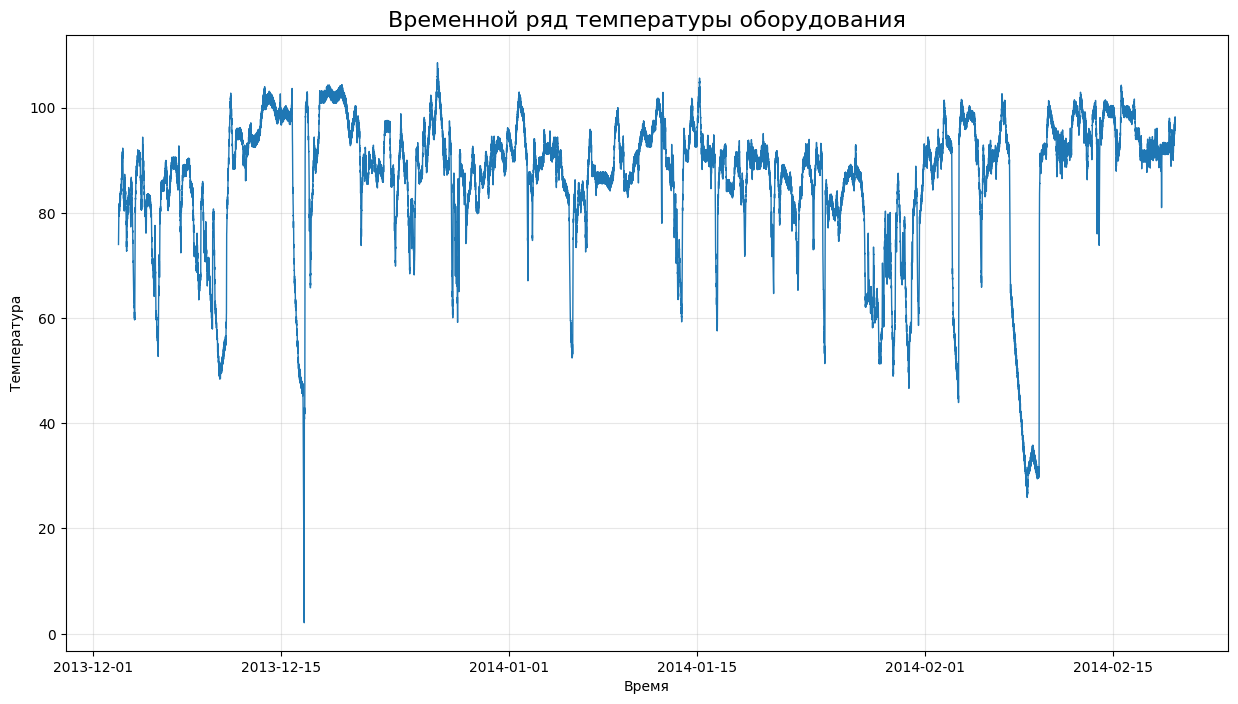

In [2]:
# Визуализация временного ряда
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['value'], linewidth=1)
plt.title('Временной ряд температуры оборудования', fontsize=16)
plt.xlabel('Время')
plt.ylabel('Температура')
plt.grid(True, alpha=0.3)
plt.show()

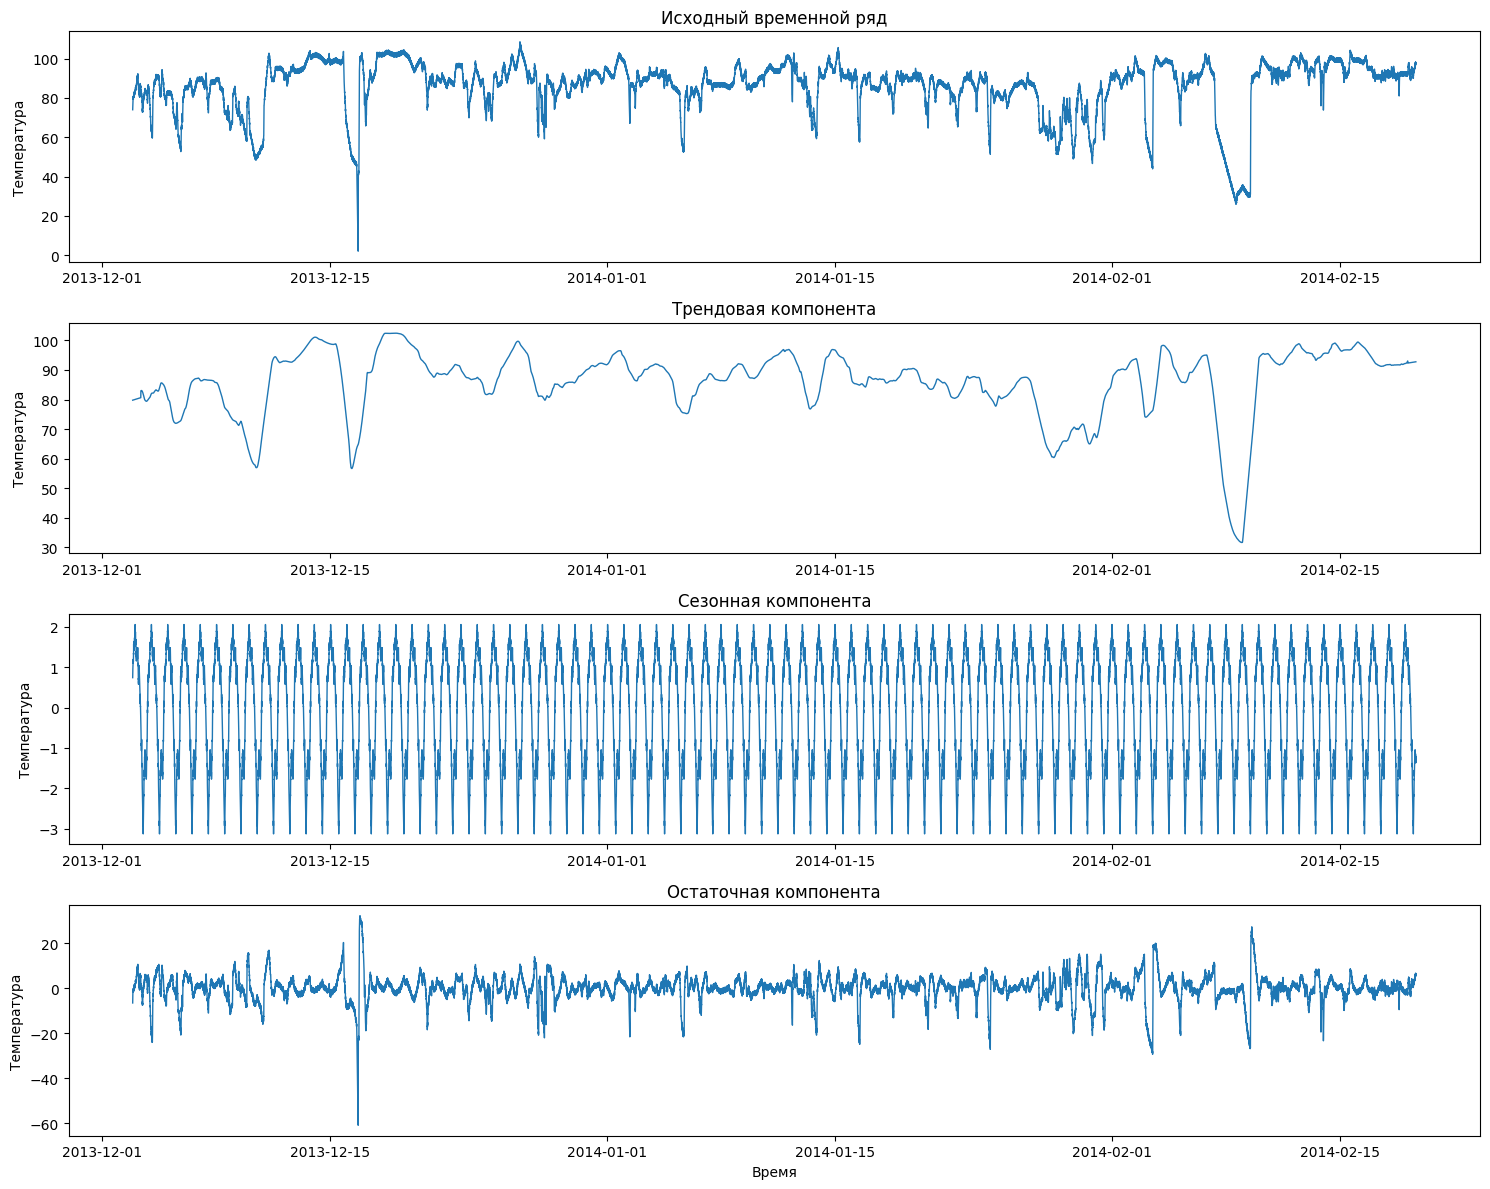

In [3]:
# Анализ компонентов временного ряда
def analyze_time_series_components(series, period=288):  # 288 = 24 часа * 12 измерений в час
    """Анализ компонентов временного ряда"""

    # Декомпозиция
    decomposition = seasonal_decompose(series, period=period, extrapolate_trend='freq')

    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    # Исходный ряд
    axes[0].plot(series.index, series.values, linewidth=1)
    axes[0].set_title('Исходный временной ряд')
    axes[0].set_ylabel('Температура')

    # Тренд
    axes[1].plot(series.index, decomposition.trend, linewidth=1)
    axes[1].set_title('Трендовая компонента')
    axes[1].set_ylabel('Температура')

    # Сезонность
    axes[2].plot(series.index, decomposition.seasonal, linewidth=1)
    axes[2].set_title('Сезонная компонента')
    axes[2].set_ylabel('Температура')

    # Остатки
    axes[3].plot(series.index, decomposition.resid, linewidth=1)
    axes[3].set_title('Остаточная компонента')
    axes[3].set_ylabel('Температура')
    axes[3].set_xlabel('Время')

    plt.tight_layout()
    plt.show()

    return decomposition

decomposition = analyze_time_series_components(df['value'])

###Анализ временного ряда
На основе визуализации можно сделать следующие наблюдения:

Тренд: В ряде наблюдается явный нисходящий тренд в конце периода, что может указывать на проблемы с оборудованием

Сезонность: Присутствует суточная сезонность (24-часовой цикл)

Стационарность: Ряд не выглядит стационарным из-за наличия тренда и сезонности


In [4]:
# Разделение на train/test
def train_test_split_time_series(data, test_size=0.2):
    """Разделение временного ряда на обучающую и тестовую выборки"""
    split_idx = int(len(data) * (1 - test_size))
    train = data.iloc[:split_idx]
    test = data.iloc[split_idx:]
    return train, test

train, test = train_test_split_time_series(df['value'], test_size=0.2)

print(f"Размер train: {len(train)}")
print(f"Размер test: {len(test)}")
print(f"Train период: {train.index.min()} - {train.index.max()}")
print(f"Test период: {test.index.min()} - {test.index.max()}")

Размер train: 18156
Размер test: 4539
Train период: 2013-12-02 21:15:00 - 2014-02-03 21:10:00
Test период: 2014-02-03 21:15:00 - 2014-02-19 15:25:00


In [5]:
# Выбор метрики
def calculate_metrics(y_true, y_pred, model_name):
    """Расчет метрик качества"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        'model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

metrics_results = []

#Прогнозирование
## Бейзлайн модели

Moving average forecast: 98.43


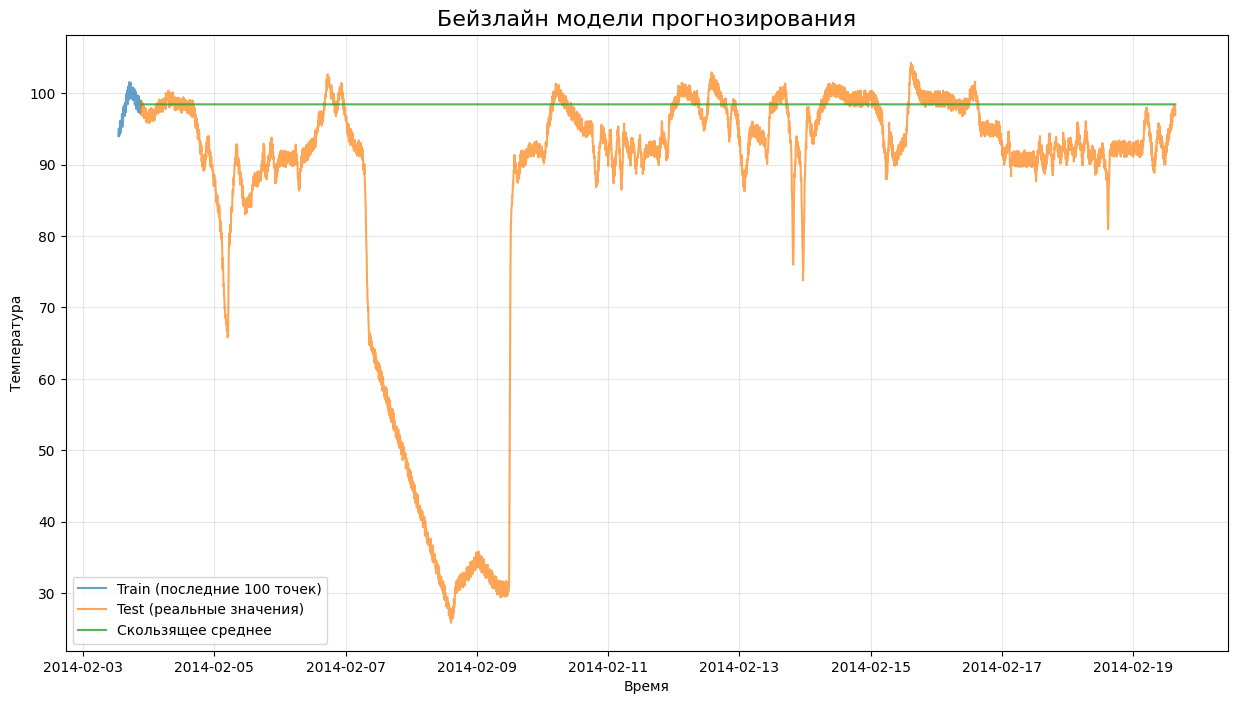

Метрики бейзлайн моделей:
Moving Average: MAE=12.2124, RMSE=22.6687, MAPE=26.70%


In [6]:
def moving_average_forecast(train, test, window=24):
    """Прогноз на основе скользящего среднего"""
    # Используем среднее последних window значений
    last_values = train.iloc[-window:].values
    prediction_value = np.mean(last_values)
    predictions = pd.Series([prediction_value] * len(test), index=test.index)
    return predictions

ma_pred = moving_average_forecast(train, test, window=24)

print(f"Moving average forecast: {ma_pred.iloc[0]:.2f}")

# Визуализация бейзлайн моделей
plt.figure(figsize=(15, 8))
plt.plot(train.index[-100:], train.values[-100:], label='Train (последние 100 точек)', alpha=0.7)
plt.plot(test.index, test.values, label='Test (реальные значения)', alpha=0.7)
plt.plot(test.index, ma_pred.values, label='Скользящее среднее', alpha=0.8)
plt.title('Бейзлайн модели прогнозирования', fontsize=16)
plt.xlabel('Время')
plt.ylabel('Температура')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Расчет метрик для бейзлайн моделей
metrics_results = []
metrics_results.append(calculate_metrics(test, ma_pred, 'Moving Average'))

print("Метрики бейзлайн моделей:")
for metric in metrics_results:
    print(f"{metric['model']}: MAE={metric['MAE']:.4f}, RMSE={metric['RMSE']:.4f}, MAPE={metric['MAPE']:.2f}%")

## Статистическая модель


In [7]:
# Тест Дики-Фуллера на стационарность
def adf_test(series, title=''):
    """Тест Дики-Фуллера на стационарность"""
    result = adfuller(series.dropna())
    print(f'ADF Test: {title}')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

    if result[1] <= 0.05:
        print("Ряд стационарен (отвергаем H0)")
    else:
        print("Ряд нестационарен (не отвергаем H0)")
    print('-' * 50)

    return result

# Тест для исходного ряда
adf_result_original = adf_test(df['value'], 'Исходный ряд')

ADF Test: Исходный ряд
ADF Statistic: -7.369503
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Ряд стационарен (отвергаем H0)
--------------------------------------------------


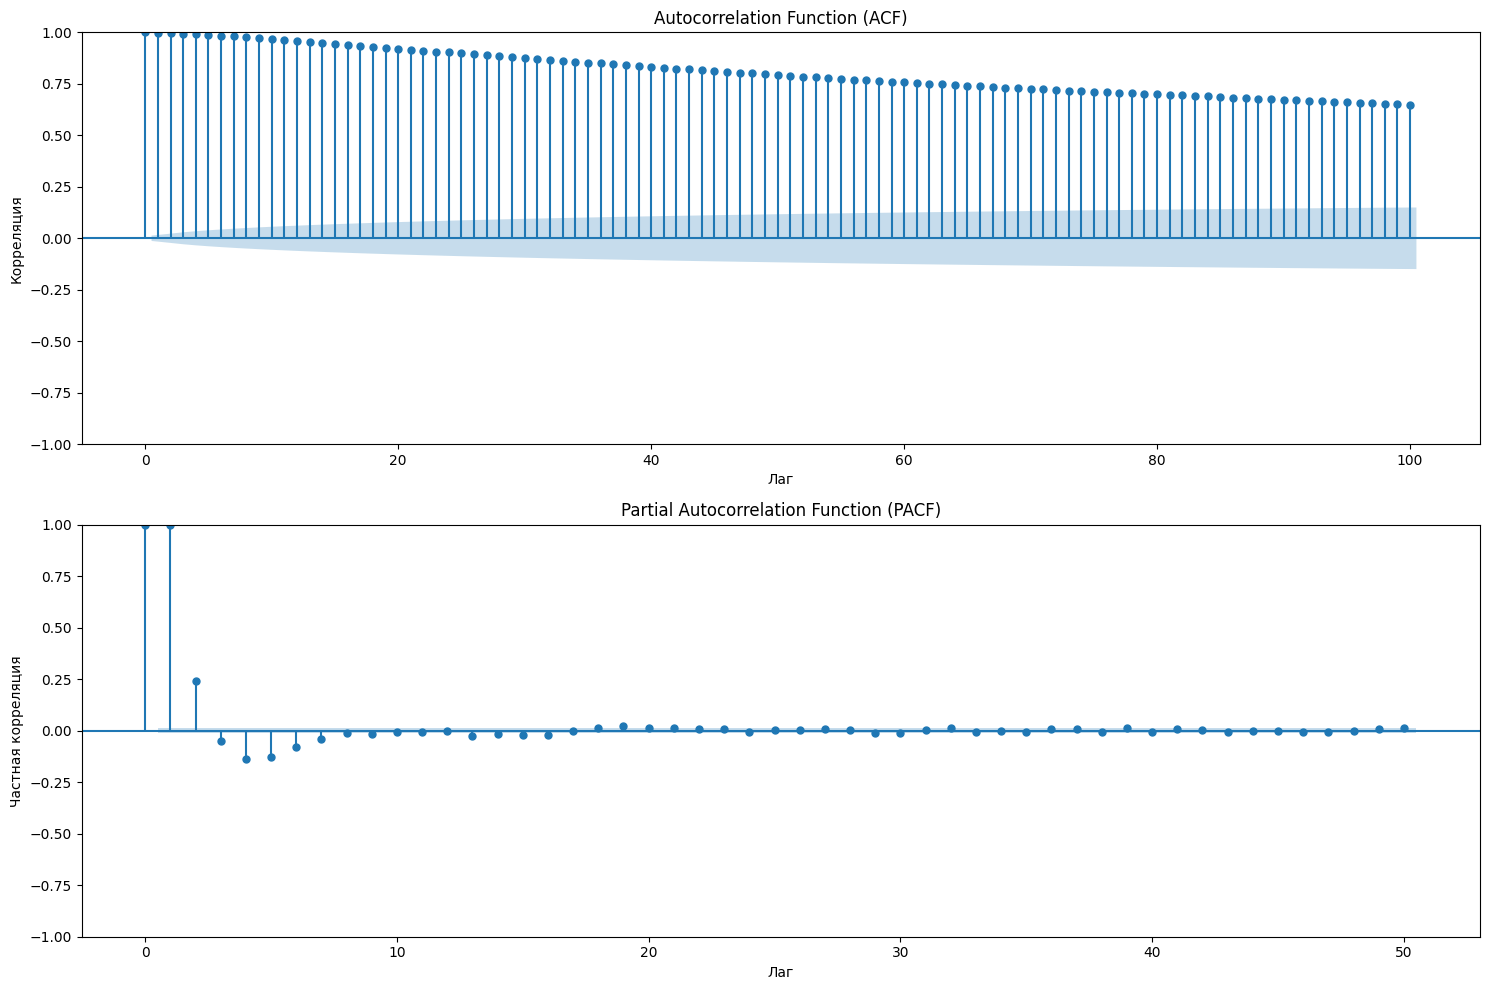

In [8]:
# ACF и PACF анализ
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

plot_acf(df['value'], ax=axes[0], lags=100, alpha=0.05)
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xlabel('Лаг')
axes[0].set_ylabel('Корреляция')

plot_pacf(df['value'], ax=axes[1], lags=50, alpha=0.05, method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Лаг')
axes[1].set_ylabel('Частная корреляция')

plt.tight_layout()
plt.show()

Анализ ACF/PACF:

ACF: Медленно затухает, что подтверждает нестационарность ряда

PACF: Значимые пики на первых нескольких лагах

Сезонность: Наблюдаются пики на лагах, кратных 24-48 (суточная сезонность)

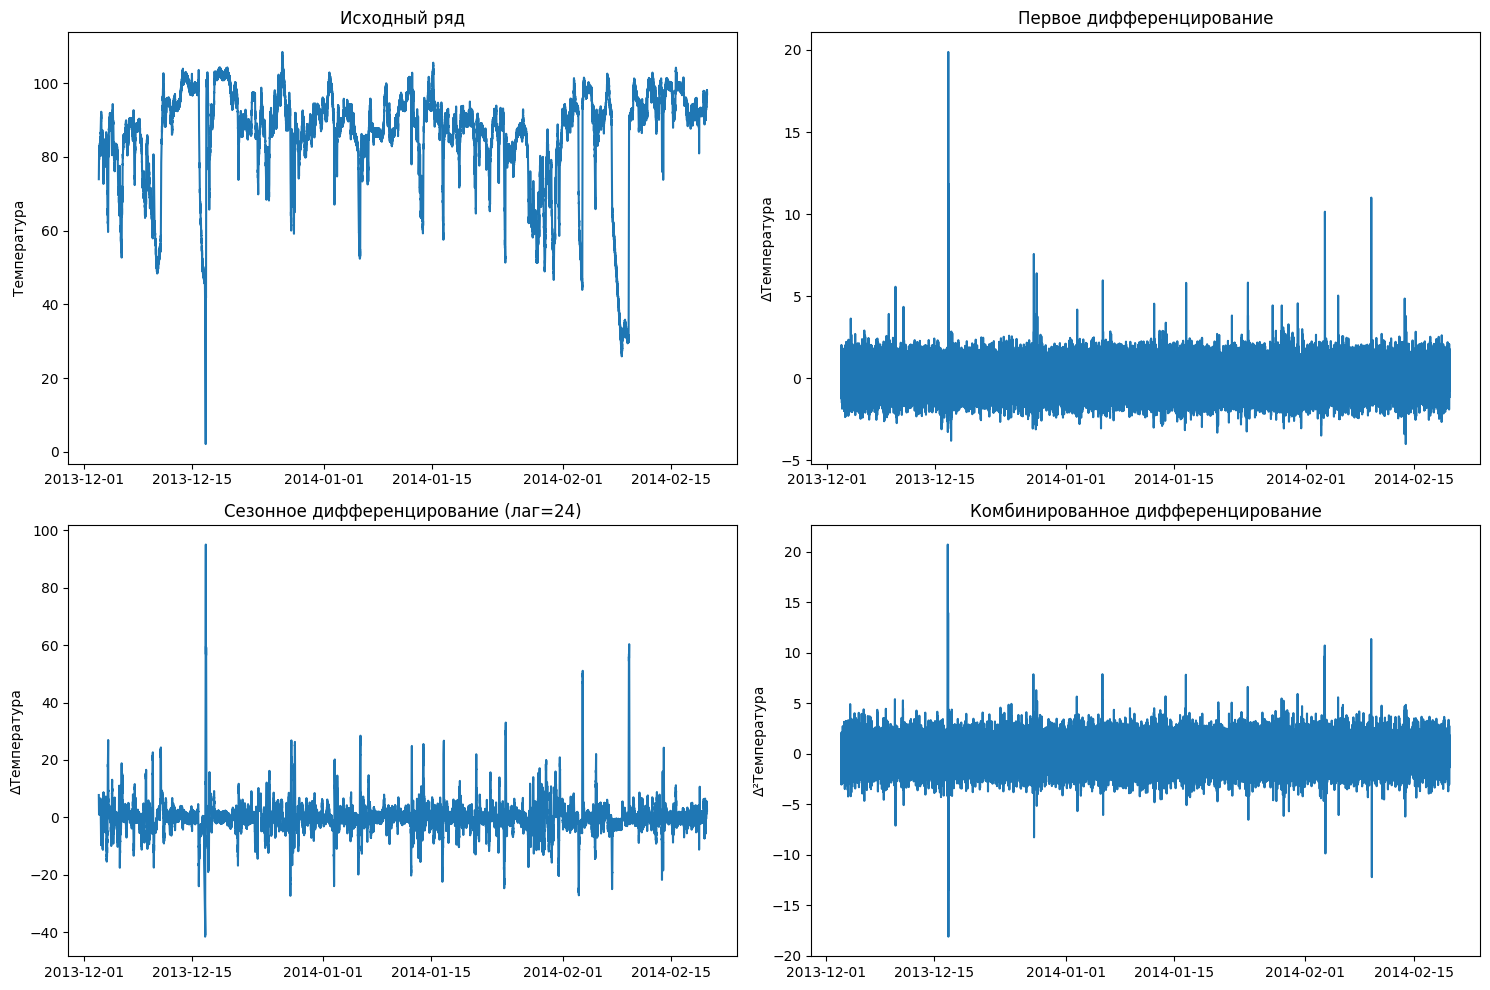

Тесты стационарности после преобразований:
ADF Test: После первого дифференцирования
ADF Statistic: -30.314918
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Ряд стационарен (отвергаем H0)
--------------------------------------------------
ADF Test: После сезонного дифференцирования
ADF Statistic: -23.691838
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Ряд стационарен (отвергаем H0)
--------------------------------------------------
ADF Test: После комбинированного дифференцирования
ADF Statistic: -35.368329
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Ряд стационарен (отвергаем H0)
--------------------------------------------------


(np.float64(-35.368328845036054),
 0.0,
 47,
 22622,
 {'1%': np.float64(-3.430639100971455),
  '5%': np.float64(-2.8616677732844655),
  '10%': np.float64(-2.5668380100862507)},
 np.float64(72017.51184740398))

In [9]:
# Преобразования для стационарности
# 1. Первое дифференцирование
df_diff1 = df['value'].diff().dropna()

# 2. Сезонное дифференцирование (24 часа)
df_seasonal_diff = df['value'].diff(24).dropna()

# 3. Комбинированное дифференцирование
df_combined_diff = df['value'].diff().diff(24).dropna()

# Визуализация преобразований
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Исходный ряд
axes[0, 0].plot(df['value'])
axes[0, 0].set_title('Исходный ряд')
axes[0, 0].set_ylabel('Температура')

# Первое дифференцирование
axes[0, 1].plot(df_diff1)
axes[0, 1].set_title('Первое дифференцирование')
axes[0, 1].set_ylabel('ΔТемпература')

# Сезонное дифференцирование
axes[1, 0].plot(df_seasonal_diff)
axes[1, 0].set_title('Сезонное дифференцирование (лаг=24)')
axes[1, 0].set_ylabel('ΔТемпература')

# Комбинированное дифференцирование
axes[1, 1].plot(df_combined_diff)
axes[1, 1].set_title('Комбинированное дифференцирование')
axes[1, 1].set_ylabel('Δ²Температура')

plt.tight_layout()
plt.show()

# Тесты стационарности для преобразованных рядов
print("Тесты стационарности после преобразований:")
adf_test(df_diff1, 'После первого дифференцирования')
adf_test(df_seasonal_diff, 'После сезонного дифференцирования')
adf_test(df_combined_diff, 'После комбинированного дифференцирования')

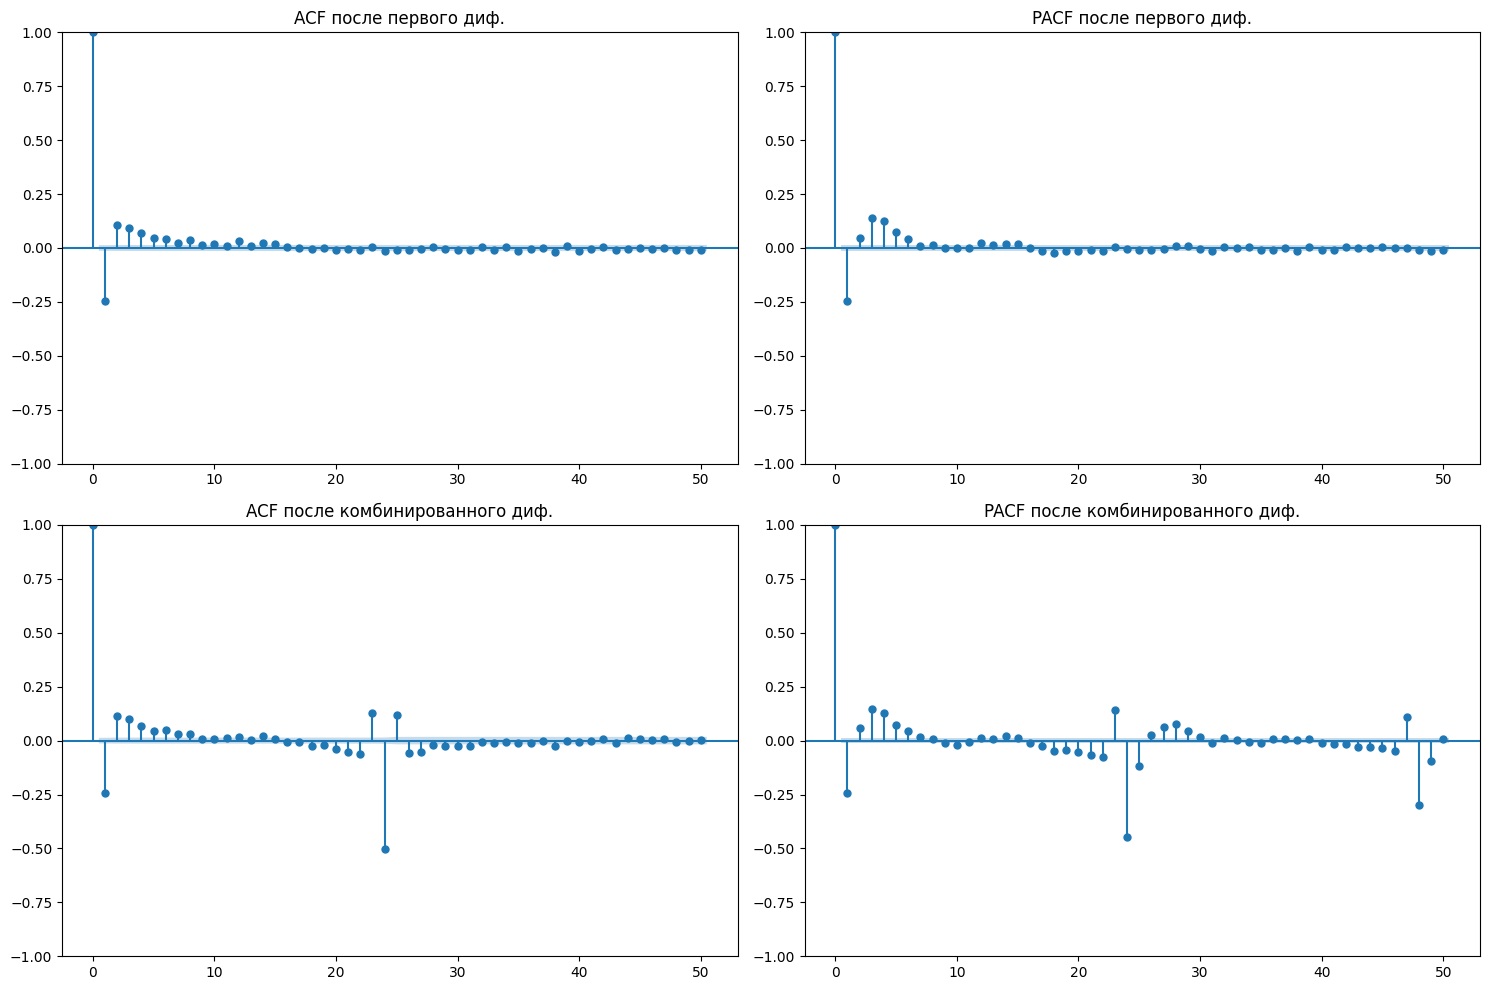

In [10]:
# ACF/PACF после дифференцирования
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

plot_acf(df_diff1, ax=axes[0, 0], lags=50, alpha=0.05)
axes[0, 0].set_title('ACF после первого диф.')

plot_pacf(df_diff1, ax=axes[0, 1], lags=50, alpha=0.05, method='ywm')
axes[0, 1].set_title('PACF после первого диф.')

plot_acf(df_combined_diff, ax=axes[1, 0], lags=50, alpha=0.05)
axes[1, 0].set_title('ACF после комбинированного диф.')

plot_pacf(df_combined_diff, ax=axes[1, 1], lags=50, alpha=0.05, method='ywm')
axes[1, 1].set_title('PACF после комбинированного диф.')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Лучшие параметры ARIMA: (2, 0, 2), AIC: 52542.64


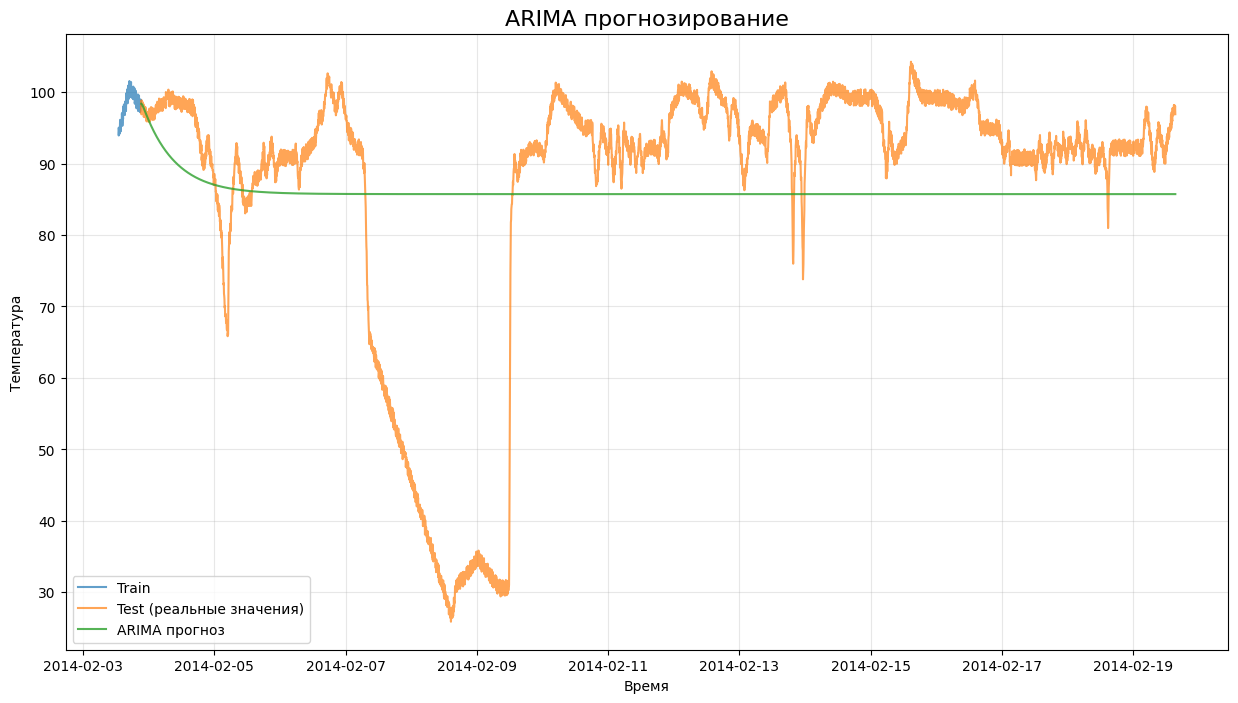

In [11]:
def arima_forecast(train, test, order=(1,1,1), seasonal_order=(1,1,1,24)):
    """Прогнозирование с помощью ARIMA"""
# Подбор параметров ARIMA
def find_best_arima(train, test, p_range=range(0, 3), d_range=range(0, 2), q_range=range(0, 3)):
    """Поиск лучших параметров ARIMA"""
    best_aic = np.inf
    best_order = None
    best_predictions = None

    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(train, order=(p, d, q))
                    fitted_model = model.fit()
                    aic = fitted_model.aic

                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)

                        # Прогноз для лучшей модели
                        forecast = fitted_model.get_forecast(steps=len(test))
                        best_predictions = forecast.predicted_mean
                        best_predictions.index = test.index

                except:
                    continue

    print(f"Лучшие параметры ARIMA: {best_order}, AIC: {best_aic:.2f}")
    return best_predictions, best_order

# Поиск лучших параметров и прогнозирование
arima_predictions, best_order = find_best_arima(train, test)

# Визуализация ARIMA
plt.figure(figsize=(15, 8))
plt.plot(train.index[-100:], train.values[-100:], label='Train', alpha=0.7)
plt.plot(test.index, test.values, label='Test (реальные значения)', alpha=0.7)

if arima_predictions is not None:
    plt.plot(test.index, arima_predictions.values, label='ARIMA прогноз', alpha=0.8)

plt.title('ARIMA прогнозирование', fontsize=16)
plt.xlabel('Время')
plt.ylabel('Температура')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Расчет метрик
if arima_predictions is not None:
    metrics_results.append(calculate_metrics(test, arima_predictions, 'ARIMA'))


## Классическая модель

In [12]:
def create_features(df, lags=24, rolling_windows=[6, 12, 24]):
    """Создание признаков для временного ряда"""
    features_df = pd.DataFrame(index=df.index)

    # Исходный признак
    features_df['value'] = df['value']

    # Лаги
    for lag in range(1, lags + 1):
        features_df[f'lag_{lag}'] = df['value'].shift(lag)

    # Скользящие статистики
    for window in rolling_windows:
        features_df[f'rolling_mean_{window}'] = df['value'].rolling(window=window, min_periods=1).mean()
        features_df[f'rolling_std_{window}'] = df['value'].rolling(window=window, min_periods=1).std()
        features_df[f'rolling_min_{window}'] = df['value'].rolling(window=window, min_periods=1).min()
        features_df[f'rolling_max_{window}'] = df['value'].rolling(window=window, min_periods=1).max()

    # Признаки времени
    features_df['hour'] = df.index.hour
    features_df['dayofweek'] = df.index.dayofweek
    features_df['dayofyear'] = df.index.dayofyear
    features_df['month'] = df.index.month

    # Сезонные признаки
    features_df['sin_hour'] = np.sin(2 * np.pi * features_df['hour'] / 24)
    features_df['cos_hour'] = np.cos(2 * np.pi * features_df['hour'] / 24)
    features_df['sin_day'] = np.sin(2 * np.pi * features_df['dayofweek'] / 7)
    features_df['cos_day'] = np.cos(2 * np.pi * features_df['dayofweek'] / 7)

    return features_df

# Создание признаков
features_df = create_features(df)

# Разделение на train/test с признаками
train_features = features_df.loc[train.index]
test_features = features_df.loc[test.index]

# Удаление строк с NaN (из-за лагов)
train_features_clean = train_features.dropna()
test_features_clean = test_features.dropna()

# Целевая переменная
X_train = train_features_clean.drop('value', axis=1)
y_train = train_features_clean['value']
X_test = test_features_clean.drop('value', axis=1)
y_test = test_features_clean['value']

print(f"Размеры после очистки: X_train {X_train.shape}, X_test {X_test.shape}")

Размеры после очистки: X_train (18156, 44), X_test (4539, 44)


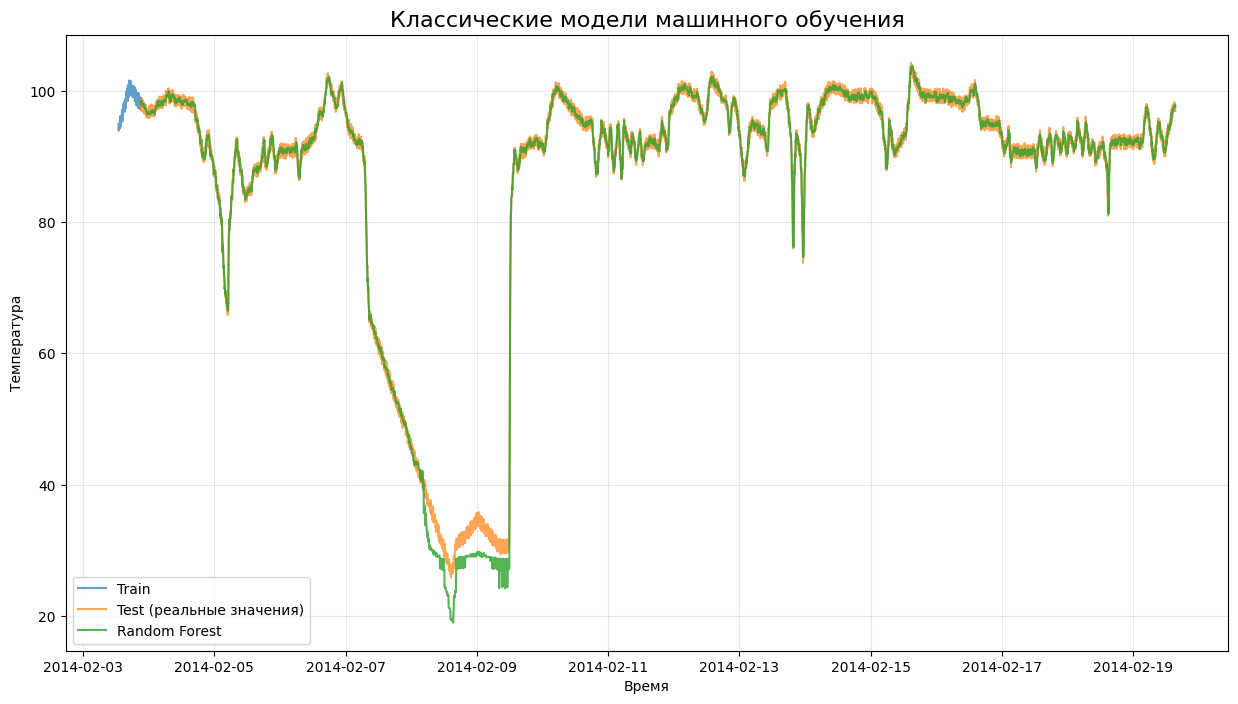

In [13]:
# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Случайный лес
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)

# Создание Series с прогнозами для согласованности
rf_predictions_series = pd.Series(rf_predictions, index=y_test.index)

# Визуализация классических моделей
plt.figure(figsize=(15, 8))
plt.plot(train.index[-100:], train.values[-100:], label='Train', alpha=0.7)
plt.plot(y_test.index, y_test.values, label='Test (реальные значения)', alpha=0.7)
plt.plot(y_test.index, rf_predictions, label='Random Forest', alpha=0.8)
plt.title('Классические модели машинного обучения', fontsize=16)
plt.xlabel('Время')
plt.ylabel('Температура')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Расчет метрик
metrics_results.append(calculate_metrics(y_test, rf_predictions_series, 'Random Forest'))

##Нейросетевая модель


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Установка seed для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

In [15]:
class TimeSeriesPreprocessor:
    """Класс для подготовки временных рядов для нейросетевых моделей"""

    def __init__(self, sequence_length=24, test_size=0.2):
        self.sequence_length = sequence_length
        self.test_size = test_size
        self.scaler = StandardScaler()

    def create_sequences(self, data):
        """Создание последовательностей для обучения"""
        sequences = []
        targets = []

        for i in range(len(data) - self.sequence_length):
            seq = data[i:i + self.sequence_length]
            target = data[i + self.sequence_length]
            sequences.append(seq)
            targets.append(target)

        return np.array(sequences), np.array(targets)

    def prepare_data(self, series):
        """Полная подготовка данных"""
        # Масштабирование
        scaled_data = self.scaler.fit_transform(series.values.reshape(-1, 1)).flatten()

        # Разделение на train/test
        split_idx = int(len(scaled_data) * (1 - self.test_size))
        train_data = scaled_data[:split_idx]
        test_data = scaled_data[split_idx:]

        # Создание последовательностей
        X_train, y_train = self.create_sequences(train_data)
        X_test, y_test = self.create_sequences(test_data)

        # Преобразование в тензоры PyTorch
        # Добавляем размерность для признаков (batch_size, seq_len, input_size)
        X_train_tensor = torch.FloatTensor(X_train).unsqueeze(-1)
        y_train_tensor = torch.FloatTensor(y_train).unsqueeze(-1)
        X_test_tensor = torch.FloatTensor(X_test).unsqueeze(-1)
        y_test_tensor = torch.FloatTensor(y_test).unsqueeze(-1)

        return (X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
                train_data, test_data, split_idx)

# Подготовка данных
preprocessor = TimeSeriesPreprocessor(sequence_length=24, test_size=0.2)
X_train, y_train, X_test, y_test, train_scaled, test_scaled, split_idx = preprocessor.prepare_data(df['value'])

print("Данные подготовлены для нейросетевых моделей:")
print(f"Размерность X_train: {X_train.shape}")  # (samples, sequence_length, features)
print(f"Размерность y_train: {y_train.shape}")
print(f"Размерность X_test: {X_test.shape}")
print(f"Размерность y_test: {y_test.shape}")

Данные подготовлены для нейросетевых моделей:
Размерность X_train: torch.Size([18132, 24, 1])
Размерность y_train: torch.Size([18132, 1])
Размерность X_test: torch.Size([4515, 24, 1])
Размерность y_test: torch.Size([4515, 1])


In [17]:
# Модель RNNModel из библиотеки ETNA
class RNNModel(nn.Module):
    """RNN модель для прогнозирования временных рядов"""

    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.2):
        super(RNNModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN слой
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            nonlinearity='tanh'
        )

        # Полносвязный слой для прогнозирования
        self.fc = nn.Linear(hidden_size, output_size)

        # Dropout для регуляризации
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Инициализация скрытого состояния
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Прямой проход через RNN
        out, hn = self.rnn(x, h0)

        # Берем только последний выход последовательности
        out = out[:, -1, :]

        # Применяем dropout
        out = self.dropout(out)

        # Полносвязный слой
        out = self.fc(out)

        return out

# Создание и проверка модели
rnn_model = RNNModel(input_size=1, hidden_size=64, num_layers=2, output_size=1)
print("RNN модель создана:")
print(rnn_model)

# Проверка прямого прохода
sample_input = torch.randn(32, 24, 1)  # batch_size=32, seq_len=24, input_size=1
sample_output = rnn_model(sample_input)
print(f"Вход: {sample_input.shape}, Выход: {sample_output.shape}")

RNN модель создана:
RNNModel(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Вход: torch.Size([32, 24, 1]), Выход: torch.Size([32, 1])


In [18]:
# Модель DeepAR с Feaure-Engineering из библиотеки ETNA

class DeepARModel(nn.Module):
    """DeepAR модель с расширенным Feature Engineering"""

    def __init__(self, input_size=10, hidden_size=128, num_layers=3, output_size=1, dropout=0.3):
        super(DeepARModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM слой (лучше для долгосрочных зависимостей)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=False
        )

        # Attention механизм
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )

        # Полносвязные слои
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)

        # Активации и регуляризация
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, x):
        # LSTM слой
        lstm_out, (hn, cn) = self.lstm(x)

        # Attention механизм
        attn_out, attn_weights = self.attention(lstm_out, lstm_out, lstm_out)

        # Residual connection + layer norm
        out = self.layer_norm(lstm_out + attn_out)

        # Берем последний временной шаг
        out = out[:, -1, :]

        # Полносвязные слои
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.fc3(out)

        return out

# Создание расширенных признаков для DeepAR
def create_deepar_features(df, sequence_length=24):
    """Создание расширенных признаков для DeepAR модели"""

    # Базовые признаки
    features = []
    targets = []

    for i in range(len(df) - sequence_length):
        # Целевая переменная
        current_data = df.iloc[i:i + sequence_length]

        # Базовые статистики
        mean_val = current_data['value'].mean()
        std_val = current_data['value'].std()
        min_val = current_data['value'].min()
        max_val = current_data['value'].max()

        # Лаги
        lags = [current_data['value'].iloc[-j] for j in range(1, 7)]  # лаги 1-6

        # Временные признаки
        timestamp = current_data.index[-1]
        hour = timestamp.hour
        dayofweek = timestamp.dayofweek
        month = timestamp.month

        # Сезонные признаки
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        day_sin = np.sin(2 * np.pi * dayofweek / 7)
        day_cos = np.cos(2 * np.pi * dayofweek / 7)

        # Собираем все признаки
        feature_vector = [mean_val, std_val, min_val, max_val] + lags + [
            hour, dayofweek, month, hour_sin, hour_cos, day_sin, day_cos
        ]

        features.append(feature_vector)
        targets.append(df['value'].iloc[i + sequence_length])

    return np.array(features), np.array(targets)

# Создание признаков для DeepAR
deepar_features, deepar_targets = create_deepar_features(df, sequence_length=24)

print("Признаки для DeepAR созданы:")
print(f"Размерность признаков: {deepar_features.shape}")
print(f"Размерность целевых значений: {deepar_targets.shape}")
print(f"Количество признаков на sample: {deepar_features.shape[1]}")

Признаки для DeepAR созданы:
Размерность признаков: (22671, 17)
Размерность целевых значений: (22671,)
Количество признаков на sample: 17


In [19]:
# Разделение на train/test для DeepAR
deepar_split_idx = int(len(deepar_features) * (1 - 0.2))
X_deepar_train = deepar_features[:deepar_split_idx]
y_deepar_train = deepar_targets[:deepar_split_idx]
X_deepar_test = deepar_features[deepar_split_idx:]
y_deepar_test = deepar_targets[deepar_split_idx:]

# Масштабирование признаков для DeepAR
deepar_scaler = StandardScaler()
X_deepar_train_scaled = deepar_scaler.fit_transform(X_deepar_train)
X_deepar_test_scaled = deepar_scaler.transform(X_deepar_test)

# Масштабирование целевой переменной для DeepAR
target_scaler = StandardScaler()
y_deepar_train_scaled = target_scaler.fit_transform(y_deepar_train.reshape(-1, 1)).flatten()
y_deepar_test_scaled = target_scaler.transform(y_deepar_test.reshape(-1, 1)).flatten()

# Преобразование в тензоры PyTorch для DeepAR
# Reshape для (batch_size, sequence_length=1, input_size) - мы уже создали признаки
X_deepar_train_tensor = torch.FloatTensor(X_deepar_train_scaled).unsqueeze(1)
y_deepar_train_tensor = torch.FloatTensor(y_deepar_train_scaled).unsqueeze(-1)
X_deepar_test_tensor = torch.FloatTensor(X_deepar_test_scaled).unsqueeze(1)
y_deepar_test_tensor = torch.FloatTensor(y_deepar_test_scaled).unsqueeze(-1)

print("Данные для DeepAR подготовлены:")
print(f"X_deepar_train: {X_deepar_train_tensor.shape}")
print(f"y_deepar_train: {y_deepar_train_tensor.shape}")
print(f"X_deepar_test: {X_deepar_test_tensor.shape}")
print(f"y_deepar_test: {y_deepar_test_tensor.shape}")

# Создание DataLoader'ов для эффективного обучения
batch_size = 32

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

deepar_train_dataset = TensorDataset(X_deepar_train_tensor, y_deepar_train_tensor)
deepar_train_loader = DataLoader(deepar_train_dataset, batch_size=batch_size, shuffle=True)

deepar_test_dataset = TensorDataset(X_deepar_test_tensor, y_deepar_test_tensor)
deepar_test_loader = DataLoader(deepar_test_dataset, batch_size=batch_size, shuffle=False)

Данные для DeepAR подготовлены:
X_deepar_train: torch.Size([18136, 1, 17])
y_deepar_train: torch.Size([18136, 1])
X_deepar_test: torch.Size([4535, 1, 17])
y_deepar_test: torch.Size([4535, 1])


In [20]:
def train_model(model, train_loader, test_loader, model_name, epochs=100, learning_rate=0.001):
    """Обучение нейросетевой модели"""

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    train_losses = []
    test_losses = []

    print(f"\nОбучение {model_name}...")

    for epoch in range(epochs):
        # Обучение
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Валидация
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()

        # Усреднение по батчам
        train_loss /= len(train_loader)
        test_loss /= len(test_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # Обновление learning rate
        scheduler.step(test_loss)

        if epoch % 20 == 0:
            print(f'Epoch {epoch:3d}/{epochs} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}')

    print(f"Обучение {model_name} завершено!")
    return train_losses, test_losses

# Обучение RNN модели
rnn_model = RNNModel(input_size=1, hidden_size=64, num_layers=2, output_size=1, dropout=0.2)
rnn_train_losses, rnn_test_losses = train_model(rnn_model, train_loader, test_loader, "RNN Model", epochs=100)

# Обучение DeepAR модели
deepar_model = DeepARModel(input_size=X_deepar_train_tensor.shape[2], hidden_size=128,
                          num_layers=3, output_size=1, dropout=0.3)
deepar_train_losses, deepar_test_losses = train_model(deepar_model, deepar_train_loader,
                                                     deepar_test_loader, "DeepAR Model", epochs=100)


Обучение RNN Model...
Epoch   0/100 | Train Loss: 0.027972 | Test Loss: 0.029761
Epoch  20/100 | Train Loss: 0.012286 | Test Loss: 0.008634
Epoch  40/100 | Train Loss: 0.010074 | Test Loss: 0.007513
Epoch  60/100 | Train Loss: 0.009384 | Test Loss: 0.005267
Epoch  80/100 | Train Loss: 0.009062 | Test Loss: 0.006297
Обучение RNN Model завершено!

Обучение DeepAR Model...
Epoch   0/100 | Train Loss: 0.139434 | Test Loss: 0.064817
Epoch  20/100 | Train Loss: 0.053449 | Test Loss: 0.076381
Epoch  40/100 | Train Loss: 0.045354 | Test Loss: 0.134536
Epoch  60/100 | Train Loss: 0.040763 | Test Loss: 0.039796
Epoch  80/100 | Train Loss: 0.040193 | Test Loss: 0.053123
Обучение DeepAR Model завершено!


In [27]:
# Прогнозирование и оценка качества

def make_predictions(model, X_data, scaler=None, is_deepar=False):
    """Создание прогнозов и обратное масштабирование"""
    model.eval()
    with torch.no_grad():
        predictions = model(X_data).numpy().flatten()

    # Обратное масштабирование
    if scaler is not None:
        if is_deepar:
            # Для DeepAR используем target_scaler
            predictions = target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        else:
            # Для RNN используем основной scaler
            predictions = preprocessor.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    return predictions

# Прогнозы RNN
rnn_predictions_scaled = make_predictions(rnn_model, X_test)
rnn_predictions = preprocessor.scaler.inverse_transform(rnn_predictions_scaled.reshape(-1, 1)).flatten()

# Прогнозы DeepAR
deepar_predictions = make_predictions(deepar_model, X_deepar_test_tensor,
                                     scaler=preprocessor.scaler, is_deepar=True)

# Подготовка реальных значений для сравнения
# Для RNN
y_test_actual = preprocessor.scaler.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()

# Для DeepAR
y_deepar_actual = y_deepar_test

# Создание временных меток для прогнозов
# Для RNN
rnn_start_idx = split_idx + preprocessor.sequence_length
rnn_timestamps = df.index[rnn_start_idx:rnn_start_idx + len(rnn_predictions)]

# Для DeepAR
deepar_start_idx = preprocessor.sequence_length
deepar_timestamps = df.index[deepar_start_idx + deepar_split_idx:deepar_start_idx + deepar_split_idx + len(deepar_predictions)]

print("Прогнозы созданы:")
print(f"RNN прогнозы: {len(rnn_predictions)} точек, временные метки: {len(rnn_timestamps)}")
print(f"DeepAR прогнозы: {len(deepar_predictions)} точек, временные метки: {len(deepar_timestamps)}")
print(f"RNN фактические значения: {len(y_test_actual)}")
print(f"DeepAR фактические значения: {len(y_deepar_actual)}")

# Выравнивание размеров для корректного отображения
min_rnn_len = min(len(rnn_timestamps), len(rnn_predictions), len(y_test_actual))
min_deepar_len = min(len(deepar_timestamps), len(deepar_predictions), len(y_deepar_actual))

print(f"\nВыравнивание размеров:")
print(f"RNN: {min_rnn_len} точек после выравнивания")
print(f"DeepAR: {min_deepar_len} точек после выравнивания")

# Обрезаем массивы до минимальной длины
rnn_timestamps = rnn_timestamps[:min_rnn_len]
rnn_predictions = rnn_predictions[:min_rnn_len]
y_test_actual = y_test_actual[:min_rnn_len]

deepar_timestamps = deepar_timestamps[:min_deepar_len]
deepar_predictions = deepar_predictions[:min_deepar_len]
y_deepar_actual = y_deepar_actual[:min_deepar_len]

Прогнозы созданы:
RNN прогнозы: 4515 точек, временные метки: 4515
DeepAR прогнозы: 4535 точек, временные метки: 4535
RNN фактические значения: 4515
DeepAR фактические значения: 4535

Выравнивание размеров:
RNN: 4515 точек после выравнивания
DeepAR: 4535 точек после выравнивания


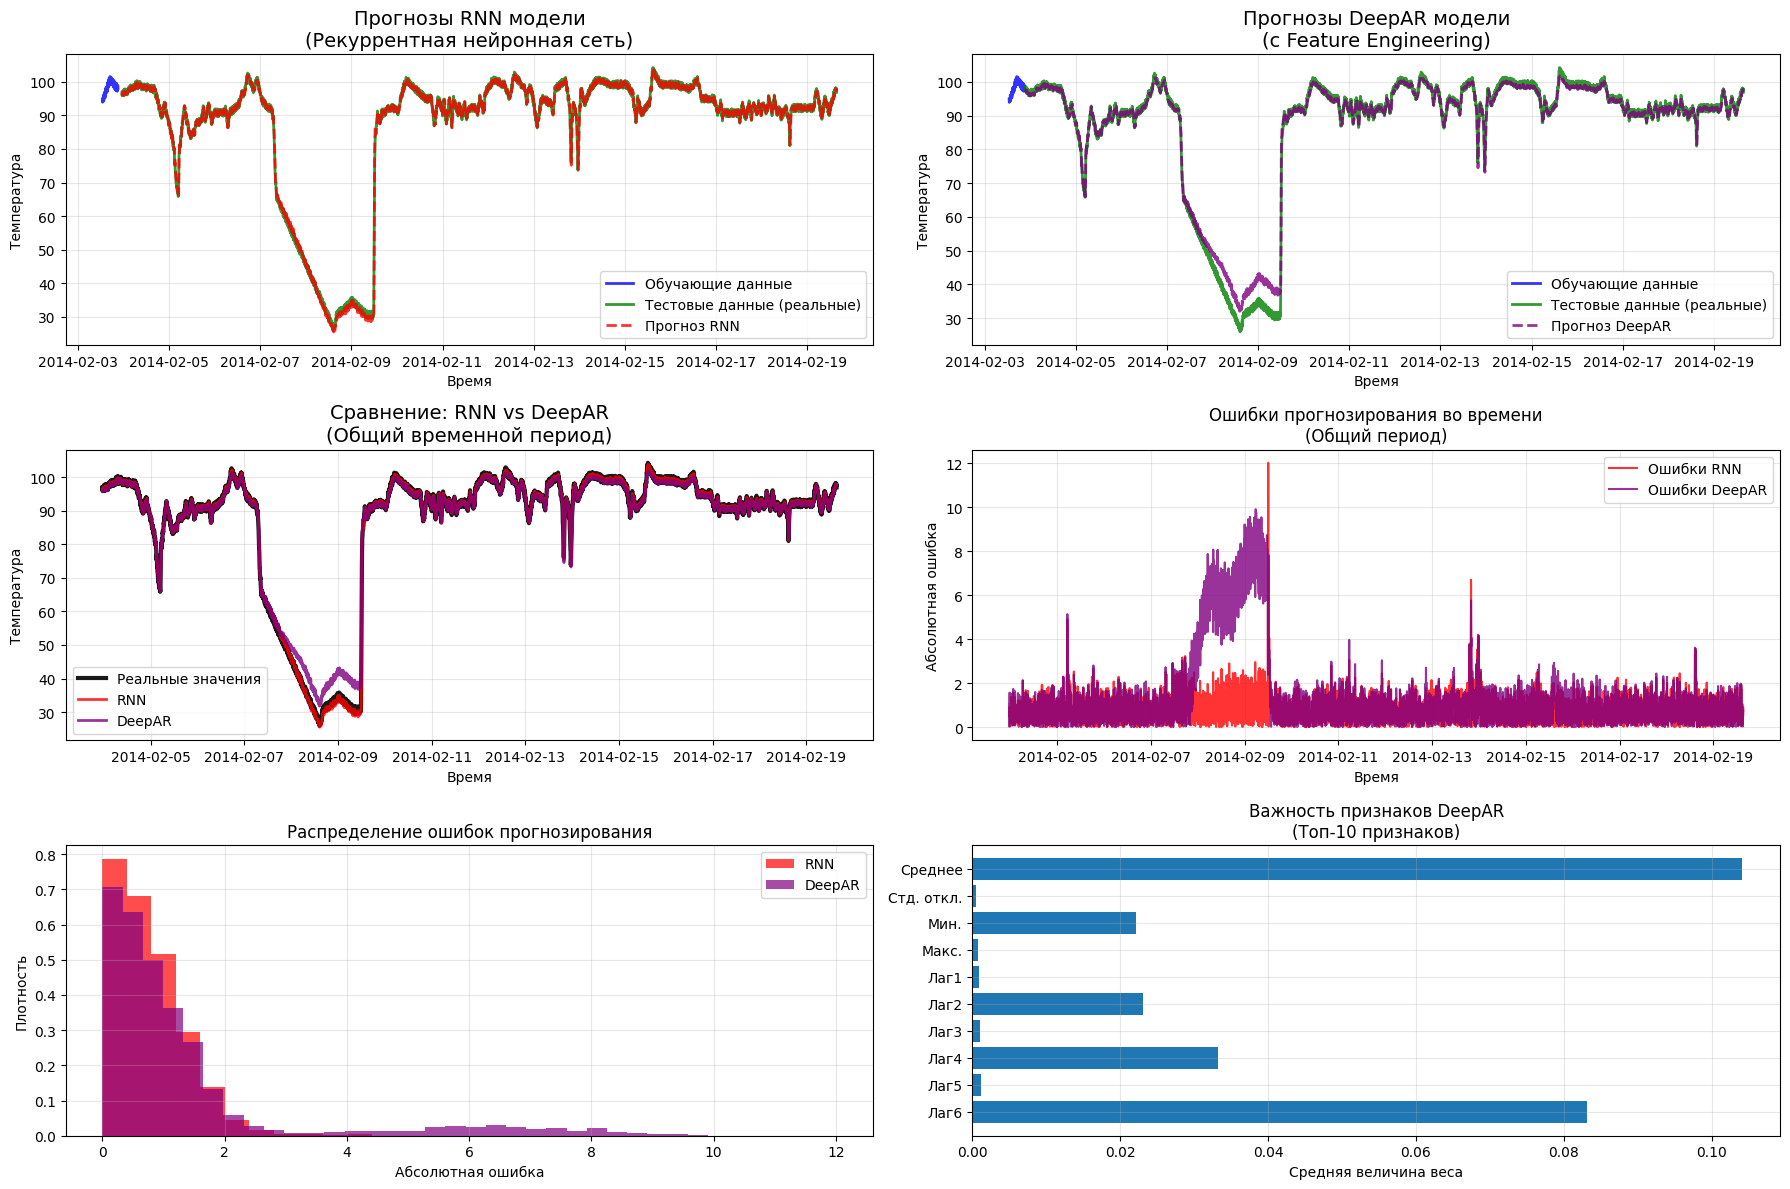

Общий период для сравнения: 2014-02-03 23:15:00 до 2014-02-19 15:25:00
Количество точек для сравнения: RNN=4515, DeepAR=4515


In [29]:
# Визуализация результатов прогнозирования
plt.figure(figsize=(18, 12))

# Определяем индексы для отображения обучающих данных
train_end_idx = split_idx
train_plot_start = max(0, train_end_idx - 100)
train_timestamps = df.index[train_plot_start:train_end_idx]
train_values = df['value'].iloc[train_plot_start:train_end_idx]

# График 1: RNN модель
plt.subplot(3, 2, 1)
plt.plot(train_timestamps, train_values,
         label='Обучающие данные', linewidth=2, alpha=0.8, color='blue')

plt.plot(rnn_timestamps, y_test_actual,
         label='Тестовые данные (реальные)', linewidth=2, alpha=0.8, color='green')

plt.plot(rnn_timestamps, rnn_predictions,
         label='Прогноз RNN', linewidth=2, alpha=0.8, color='red', linestyle='--')

plt.title('Прогнозы RNN модели\n(Рекуррентная нейронная сеть)', fontsize=14)
plt.xlabel('Время')
plt.ylabel('Температура')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: DeepAR модель
plt.subplot(3, 2, 2)
plt.plot(train_timestamps, train_values,
         label='Обучающие данные', linewidth=2, alpha=0.8, color='blue')

plt.plot(deepar_timestamps, y_deepar_actual,
         label='Тестовые данные (реальные)', linewidth=2, alpha=0.8, color='green')

plt.plot(deepar_timestamps, deepar_predictions,
         label='Прогноз DeepAR', linewidth=2, alpha=0.8, color='purple', linestyle='--')

plt.title('Прогнозы DeepAR модели\n(с Feature Engineering)', fontsize=14)
plt.xlabel('Время')
plt.ylabel('Температура')
plt.legend()
plt.grid(True, alpha=0.3)

# График 3: Сравнение обеих моделей
plt.subplot(3, 2, 3)
# Находим общие временные метки для сравнения
common_start = max(rnn_timestamps[0], deepar_timestamps[0])
common_end = min(rnn_timestamps[-1], deepar_timestamps[-1])

# Фильтруем данные по общему временному диапазону
rnn_mask = (rnn_timestamps >= common_start) & (rnn_timestamps <= common_end)
deepar_mask = (deepar_timestamps >= common_start) & (deepar_timestamps <= common_end)

common_rnn_timestamps = rnn_timestamps[rnn_mask]
common_rnn_actual = y_test_actual[rnn_mask]
common_rnn_pred = rnn_predictions[rnn_mask]

common_deepar_timestamps = deepar_timestamps[deepar_mask]
common_deepar_actual = y_deepar_actual[deepar_mask]
common_deepar_pred = deepar_predictions[deepar_mask]

plt.plot(common_rnn_timestamps, common_rnn_actual,
         label='Реальные значения', linewidth=3, alpha=0.9, color='black')

plt.plot(common_rnn_timestamps, common_rnn_pred,
         label='RNN', linewidth=2, alpha=0.8, color='red')

plt.plot(common_deepar_timestamps, common_deepar_pred,
         label='DeepAR', linewidth=2, alpha=0.8, color='purple')

plt.title('Сравнение: RNN vs DeepAR\n(Общий временной период)', fontsize=14)
plt.xlabel('Время')
plt.ylabel('Температура')
plt.legend()
plt.grid(True, alpha=0.3)

# График 4: Ошибки прогнозирования
plt.subplot(3, 2, 4)
rnn_errors = np.abs(common_rnn_actual - common_rnn_pred)
deepar_errors = np.abs(common_deepar_actual - common_deepar_pred)

plt.plot(common_rnn_timestamps, rnn_errors, label='Ошибки RNN', alpha=0.8, color='red')
plt.plot(common_deepar_timestamps, deepar_errors, label='Ошибки DeepAR', alpha=0.8, color='purple')
plt.title('Ошибки прогнозирования во времени\n(Общий период)')
plt.xlabel('Время')
plt.ylabel('Абсолютная ошибка')
plt.legend()
plt.grid(True, alpha=0.3)

# График 5: Распределение ошибок
plt.subplot(3, 2, 5)
plt.hist(rnn_errors, bins=30, alpha=0.7, label='RNN', color='red', density=True)
plt.hist(deepar_errors, bins=30, alpha=0.7, label='DeepAR', color='purple', density=True)
plt.title('Распределение ошибок прогнозирования')
plt.xlabel('Абсолютная ошибка')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, alpha=0.3)

# График 6: Важность признаков (для DeepAR)
plt.subplot(3, 2, 6)
feature_names = ['Среднее', 'Стд. откл.', 'Мин.', 'Макс.', 'Лаг1', 'Лаг2', 'Лаг3', 'Лаг4', 'Лаг5', 'Лаг6',
                'Час', 'День недели', 'Месяц', 'Час_sin', 'Час_cos', 'День_sin', 'День_cos']

# Простой анализ важности признаков через веса первой линейного слоя
if hasattr(deepar_model.fc1, 'weight'):
    feature_importance = torch.mean(torch.abs(deepar_model.fc1.weight), dim=0).detach().numpy()
    # Берем только первые 10 признаков для наглядности
    plt.barh(range(min(10, len(feature_importance))),
             feature_importance[:10][::-1])  # reverse для лучшего отображения
    plt.yticks(range(min(10, len(feature_importance))), feature_names[:10][::-1])
    plt.title('Важность признаков DeepAR\n(Топ-10 признаков)')
    plt.xlabel('Средняя величина веса')
else:
    plt.text(0.5, 0.5, 'Важность признаков\nнедоступна',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Важность признаков DeepAR')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Общий период для сравнения: {common_start} до {common_end}")
print(f"Количество точек для сравнения: RNN={len(common_rnn_timestamps)}, DeepAR={len(common_deepar_timestamps)}")

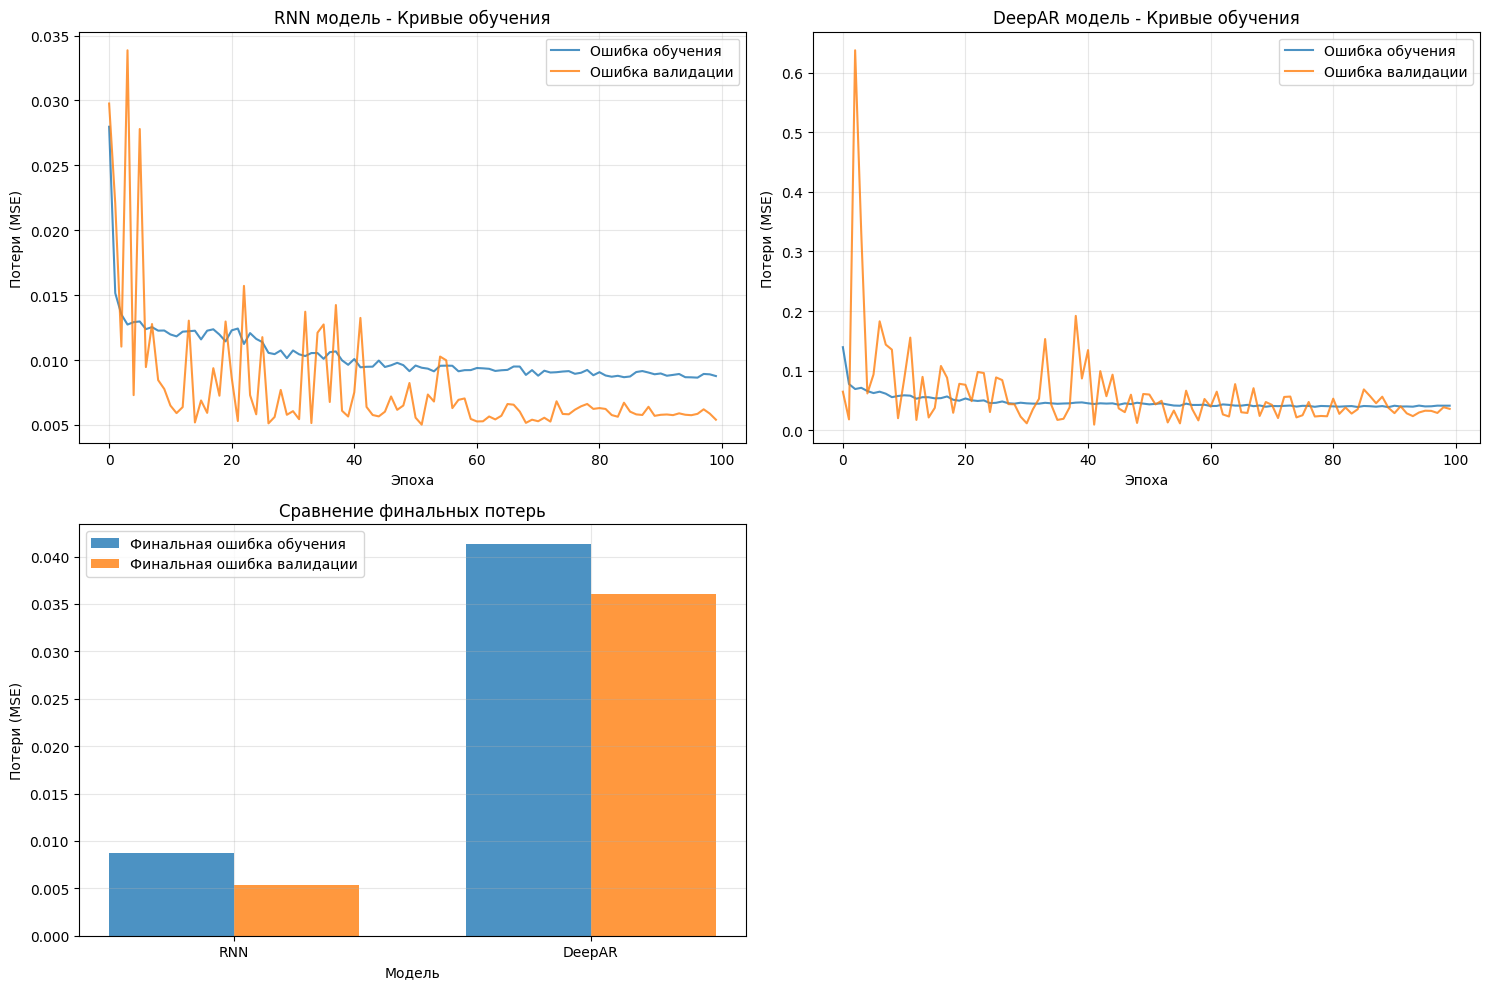

Сравнение финальных потерь:
RNN - Ошибка обучения: 0.008764, Ошибка валидации: 0.005403
DeepAR - Ошибка обучения: 0.041372, Ошибка валидации: 0.036044


In [30]:
plt.figure(figsize=(15, 10))

# Графики потерь RNN
plt.subplot(2, 2, 1)
plt.plot(rnn_train_losses, label='Ошибка обучения', alpha=0.8)
plt.plot(rnn_test_losses, label='Ошибка валидации', alpha=0.8)
plt.title('RNN модель - Кривые обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потери (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

# Графики потерь DeepAR
plt.subplot(2, 2, 2)
plt.plot(deepar_train_losses, label='Ошибка обучения', alpha=0.8)
plt.plot(deepar_test_losses, label='Ошибка валидации', alpha=0.8)
plt.title('DeepAR модель - Кривые обучения')
plt.xlabel('Эпоха')
plt.ylabel('Потери (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

# Сравнение финальных потерь
plt.subplot(2, 2, 3)
models = ['RNN', 'DeepAR']
final_train_losses = [rnn_train_losses[-1], deepar_train_losses[-1]]
final_test_losses = [rnn_test_losses[-1], deepar_test_losses[-1]]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, final_train_losses, width, label='Финальная ошибка обучения', alpha=0.8)
plt.bar(x + width/2, final_test_losses, width, label='Финальная ошибка валидации', alpha=0.8)
plt.title('Сравнение финальных потерь')
plt.xlabel('Модель')
plt.ylabel('Потери (MSE)')
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Сравнение финальных потерь:")
print(f"RNN - Ошибка обучения: {rnn_train_losses[-1]:.6f}, Ошибка валидации: {rnn_test_losses[-1]:.6f}")
print(f"DeepAR - Ошибка обучения: {deepar_train_losses[-1]:.6f}, Ошибка валидации: {deepar_test_losses[-1]:.6f}")

In [31]:
def calculate_neural_metrics(y_true, y_pred, model_name):
    """Расчет метрик для нейросетевых моделей"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        'model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Max_Error': np.max(np.abs(y_true - y_pred)),
        'Std_Error': np.std(np.abs(y_true - y_pred))
    }

# Расчет метрик для RNN (используем выровненные данные)
rnn_metrics = calculate_neural_metrics(common_rnn_actual, common_rnn_pred, 'Neural RNN')

# Расчет метрик для DeepAR (используем выровненные данные)
deepar_metrics = calculate_neural_metrics(common_deepar_actual, common_deepar_pred, 'Neural DeepAR')

# Создание таблицы метрик
neural_metrics_df = pd.DataFrame([rnn_metrics, deepar_metrics])
neural_metrics_df = neural_metrics_df.set_index('model')

print("МЕТРИКИ КАЧЕСТВА НЕЙРОСЕТЕВЫХ МОДЕЛЕЙ:")
print("=" * 75)
print(neural_metrics_df.round(4))
print("=" * 75)

# Детальный анализ
print("\nДЕТАЛЬНЫЙ АНАЛИЗ:")
print(f"RNN модель (на {len(common_rnn_actual)} точках):")
print(f"  - Средняя абсолютная ошибка (MAE): {rnn_metrics['MAE']:.4f}")
print(f"  - Среднеквадратичная ошибка (RMSE): {rnn_metrics['RMSE']:.4f}")
print(f"  - Средняя абсолютная процентная ошибка (MAPE): {rnn_metrics['MAPE']:.2f}%")
print(f"  - Точность: {100 - rnn_metrics['MAPE']:.2f}%")
print(f"  - Максимальная ошибка: {rnn_metrics['Max_Error']:.4f}")
print(f"  - Стандартное отклонение ошибки: {rnn_metrics['Std_Error']:.4f}")

print(f"\nDeepAR модель (на {len(common_deepar_actual)} точках):")
print(f"  - Средняя абсолютная ошибка (MAE): {deepar_metrics['MAE']:.4f}")
print(f"  - Среднеквадратичная ошибка (RMSE): {deepar_metrics['RMSE']:.4f}")
print(f"  - Средняя абсолютная процентная ошибка (MAPE): {deepar_metrics['MAPE']:.2f}%")
print(f"  - Точность: {100 - deepar_metrics['MAPE']:.2f}%")
print(f"  - Максимальная ошибка: {deepar_metrics['Max_Error']:.4f}")
print(f"  - Стандартное отклонение ошибки: {deepar_metrics['Std_Error']:.4f}")

# Сравнение улучшения
improvement_mae = ((rnn_metrics['MAE'] - deepar_metrics['MAE']) / rnn_metrics['MAE']) * 100
improvement_rmse = ((rnn_metrics['RMSE'] - deepar_metrics['RMSE']) / rnn_metrics['RMSE']) * 100
improvement_mape = ((rnn_metrics['MAPE'] - deepar_metrics['MAPE']) / rnn_metrics['MAPE']) * 100

print(f"\nСРАВНЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ:")
print(f"  Улучшение MAE: {improvement_mae:+.2f}%")
print(f"  Улучшение RMSE: {improvement_rmse:+.2f}%")
print(f"  Улучшение MAPE: {improvement_mape:+.2f}%")

if improvement_mae > 0:
    print(f"  ✅ DeepAR показывает лучшее качество на {improvement_mae:.2f}% по MAE")
else:
    print(f"  ✅ RNN показывает лучшее качество на {-improvement_mae:.2f}% по MAE")

# Анализ стабильности
print(f"\nАНАЛИЗ СТАБИЛЬНОСТИ:")
print(f"  RNN - Стандартное отклонение ошибки: {rnn_metrics['Std_Error']:.4f}")
print(f"  DeepAR - Стандартное отклонение ошибки: {deepar_metrics['Std_Error']:.4f}")

if deepar_metrics['Std_Error'] < rnn_metrics['Std_Error']:
    print(f"  ✅ DeepAR более стабильная модель (меньше разброс ошибок)")
else:
    print(f"  ✅ RNN более стабильная модель (меньше разброс ошибок)")

МЕТРИКИ КАЧЕСТВА НЕЙРОСЕТЕВЫХ МОДЕЛЕЙ:
                  MAE    RMSE    MAPE  Max_Error  Std_Error
model                                                      
Neural RNN     0.7780  1.0118  1.0504    12.0098     0.6470
Neural DeepAR  1.3528  2.2668  2.7078     9.9047     1.8189

ДЕТАЛЬНЫЙ АНАЛИЗ:
RNN модель (на 4515 точках):
  - Средняя абсолютная ошибка (MAE): 0.7780
  - Среднеквадратичная ошибка (RMSE): 1.0118
  - Средняя абсолютная процентная ошибка (MAPE): 1.05%
  - Точность: 98.95%
  - Максимальная ошибка: 12.0098
  - Стандартное отклонение ошибки: 0.6470

DeepAR модель (на 4515 точках):
  - Средняя абсолютная ошибка (MAE): 1.3528
  - Среднеквадратичная ошибка (RMSE): 2.2668
  - Средняя абсолютная процентная ошибка (MAPE): 2.71%
  - Точность: 97.29%
  - Максимальная ошибка: 9.9047
  - Стандартное отклонение ошибки: 1.8189

СРАВНЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ:
  Улучшение MAE: -73.89%
  Улучшение RMSE: -124.03%
  Улучшение MAPE: -157.79%
  ✅ RNN показывает лучшее качество на 73.89% по MAE

## Сбор всех метрик в отдельный датафрейм, сравнение, выводы

Сравнение метрик всех моделей:
                    MAE     RMSE     MAPE
model                                    
Moving Average  12.2124  22.6687  26.6991
ARIMA           13.4618  19.3103  24.9462
Random Forest    0.8360   1.4667   1.6626


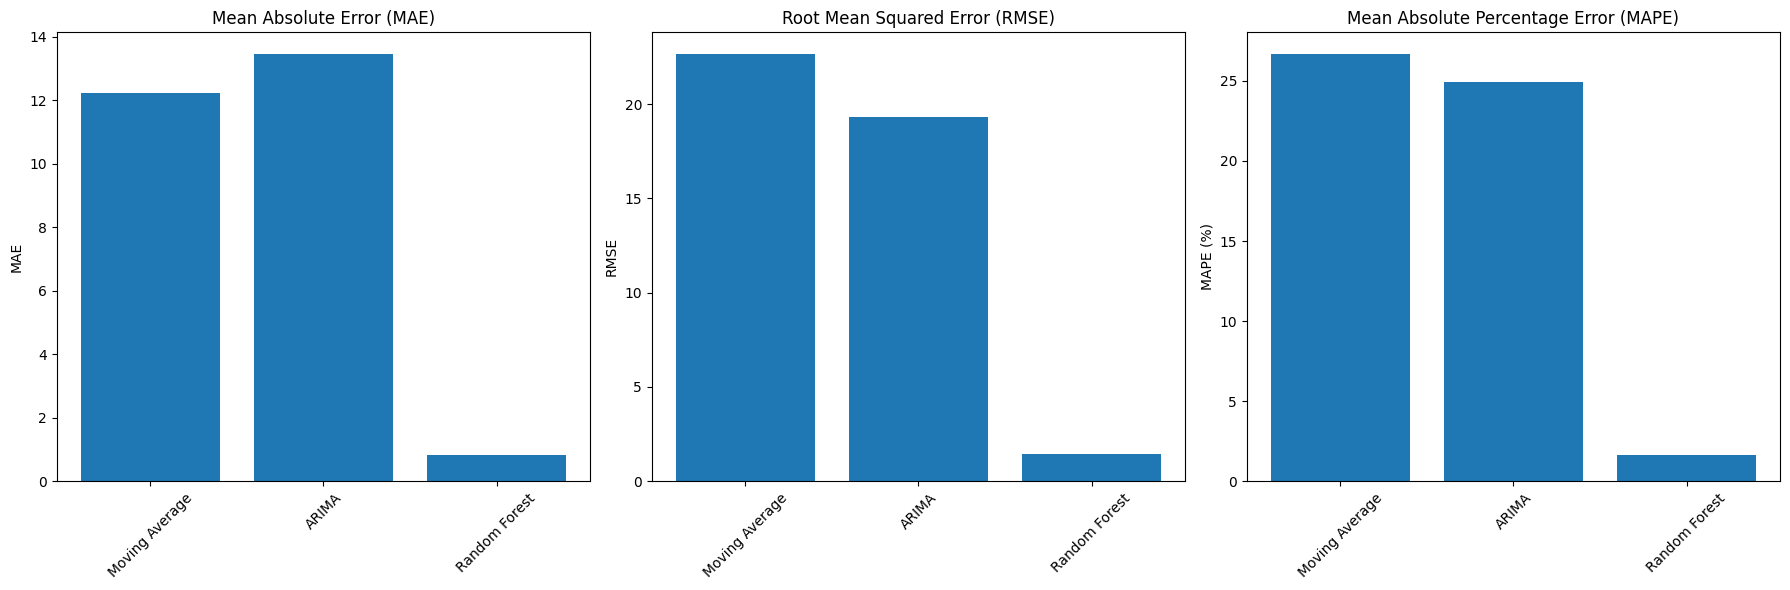

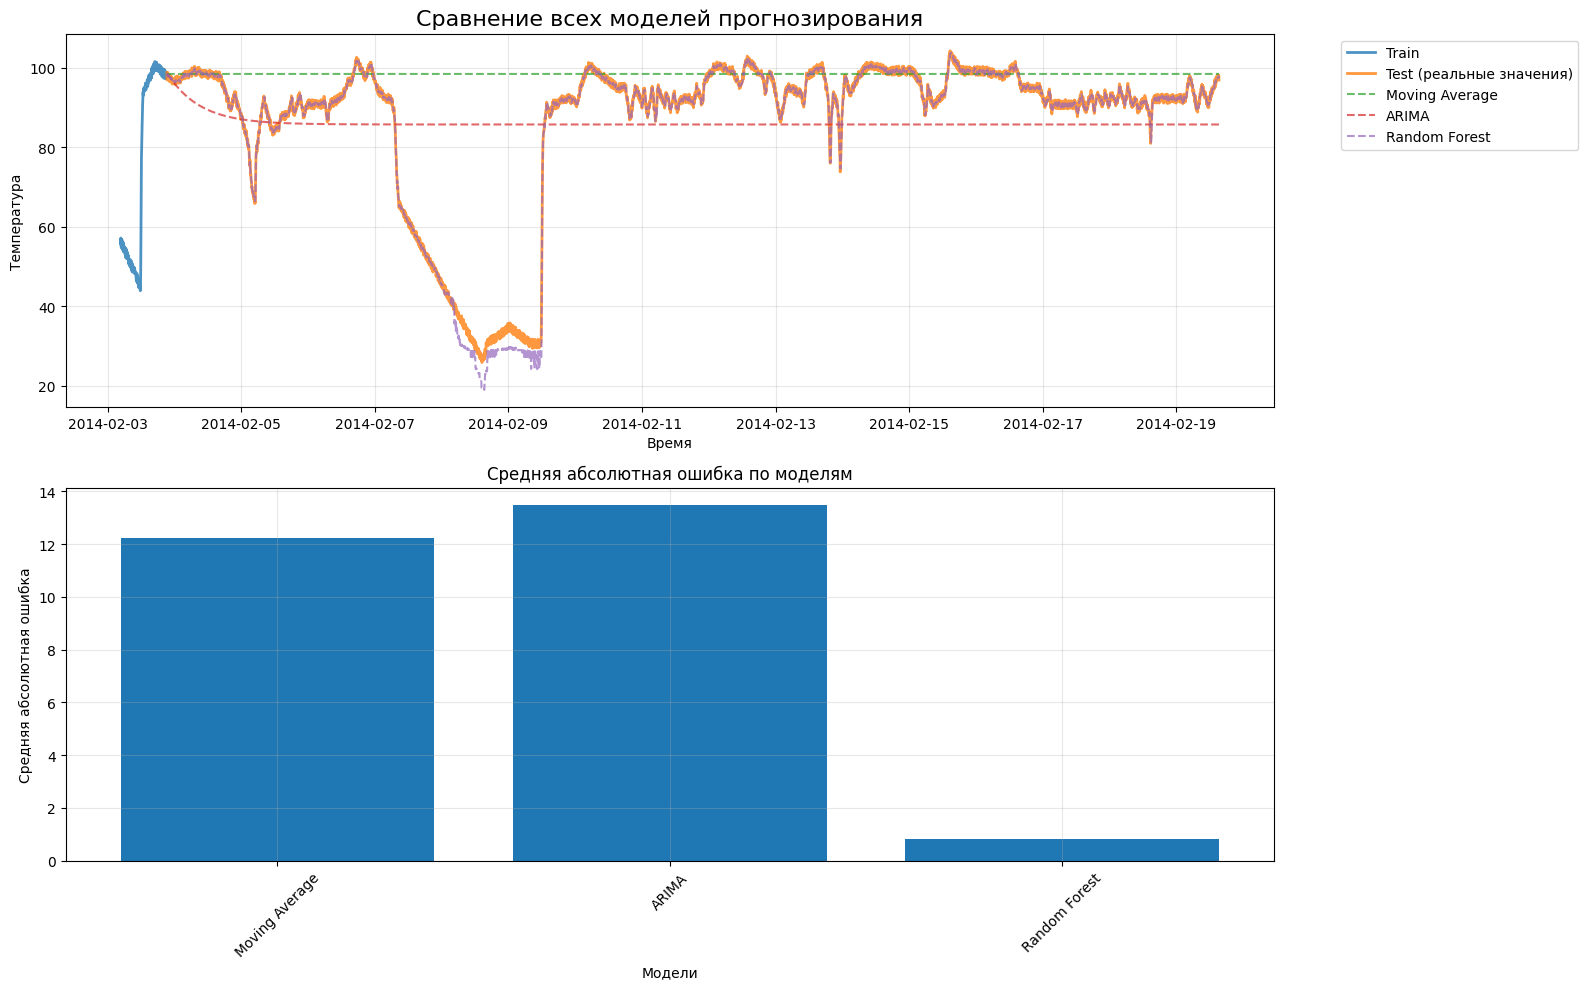

In [34]:
# Сбор всех метрик в один DataFrame
metrics_df = pd.DataFrame(metrics_results)
metrics_df = metrics_df.set_index('model')

print("Сравнение метрик всех моделей:")
print(metrics_df.round(4))

# Визуализация сравнения моделей
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# MAE
axes[0].bar(metrics_df.index, metrics_df['MAE'])
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_ylabel('MAE')
axes[0].tick_params(axis='x', rotation=45)

# RMSE
axes[1].bar(metrics_df.index, metrics_df['RMSE'])
axes[1].set_title('Root Mean Squared Error (RMSE)')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=45)

# MAPE
axes[2].bar(metrics_df.index, metrics_df['MAPE'])
axes[2].set_title('Mean Absolute Percentage Error (MAPE)')
axes[2].set_ylabel('MAPE (%)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Финальная визуализация всех прогнозов
plt.figure(figsize=(16, 10))

# Основной график
plt.subplot(2, 1, 1)
plt.plot(train.index[-200:], train.values[-200:], label='Train', linewidth=2, alpha=0.8)
plt.plot(test.index, test.values, label='Test (реальные значения)', linewidth=2, alpha=0.8)

# Добавление прогнозов всех моделей
plt.plot(test.index, ma_pred.values, label='Moving Average', alpha=0.7, linestyle='--')

if arima_predictions is not None:
    plt.plot(test.index, arima_predictions.values, label='ARIMA', alpha=0.7, linestyle='--')

plt.plot(rf_predictions_series.index, rf_predictions_series.values, label='Random Forest', alpha=0.7, linestyle='--')

plt.title('Сравнение всех моделей прогнозирования', fontsize=16)
plt.xlabel('Время')
plt.ylabel('Температура')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# График ошибок
plt.subplot(2, 1, 2)
models = metrics_df.index
mae_values = metrics_df['MAE']

plt.bar(models, mae_values)
plt.title('Средняя абсолютная ошибка по моделям')
plt.xlabel('Модели')
plt.ylabel('Средняя абсолютная ошибка')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
# Выводы

print("ВЫВОДЫ И РЕКОМЕНДАЦИИ")


print(f"\n1. КАЧЕСТВО МОДЕЛЕЙ (по RMSE):")
best_model_rmse = metrics_df.loc[metrics_df['RMSE'].idxmin()]
print(f"   Лучшая модель: {best_model_rmse.name} (RMSE: {best_model_rmse['RMSE']:.4f})")

print(f"\n2. КАЧЕСТВО МОДЕЛЕЙ (по MAPE):")
best_model_mape = metrics_df.loc[metrics_df['MAPE'].idxmin()]
print(f"   Лучшая модель: {best_model_mape.name} (MAPE: {best_model_mape['MAPE']:.2f}%)")

print(f"\n3. СТАБИЛЬНОСТЬ МОДЕЛЕЙ:")
print("   Относительная производительность моделей (по RMSE):")
for model in metrics_df.index:
    rmse_ratio = metrics_df.loc[model, 'RMSE'] / best_model_rmse['RMSE']
    print(f"   {model}: {rmse_ratio:.2f}x от лучшей модели")


ВЫВОДЫ И РЕКОМЕНДАЦИИ

1. КАЧЕСТВО МОДЕЛЕЙ (по RMSE):
   Лучшая модель: Random Forest (RMSE: 1.4667)

2. КАЧЕСТВО МОДЕЛЕЙ (по MAPE):
   Лучшая модель: Random Forest (MAPE: 1.66%)

3. СТАБИЛЬНОСТЬ МОДЕЛЕЙ:
   Относительная производительность моделей (по RMSE):
   Moving Average: 15.46x от лучшей модели
   ARIMA: 13.17x от лучшей модели
   Random Forest: 1.00x от лучшей модели
